In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'CTC-A.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2004-03-31,1414,-1284,130,41,314,513,615,2058,41,...,4668,885,0,244,1157,1085,2327,127,-58,80.87
1,2004-06-30,1927,-1730,197,81,316,330,711,2056,41,...,4721,941,0,156,1129,1084,2298,157,-100,80.91
2,2004-09-30,1715,-1537,178,69,184,482,750,2174,41,...,4918,1091,0,156,1288,1083,2455,155,-64,81.11
3,2004-12-31,2096,-1866,230,100,802,371,621,2435,42,...,5243,1438,0,6,1487,1081,2692,39,-118,81.05
4,2005-03-31,1519,-1391,128,35,54,575,802,2035,42,...,4969,1050,0,206,1610,670,2380,141,-78,81.30


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
75,2022-12-31,2023-02-11,58.50,5340,-3322,2018,563,331,1310,3216,...,2342,22102,3201,0,1040,7147,3217,15063,911,-182
76,2023-03-31,2023-04-21,57.43,3707,-2425,1282,43,312,1508,3280,...,2288,22163,2849,0,985,7498,3218,15460,-311,-159
77,2023-06-30,2023-07-21,56.55,4256,-2807,1449,127,433,863,3214,...,2248,21840,2926,0,1545,7704,2659,15283,823,-74
78,2023-09-30,2023-10-21,55.76,4250,-2814,1436,-28,459,1524,3360,...,2256,22713,2990,0,561,6999,3754,16212,-29,-162
79,2023-12-31,2024-02-11,55.76,4443,-2906,1537,197,311,1151,2693,...,2255,21978,2689,0,561,6389,4404,15533,870,-353


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
75,2022-12-31,2023-02-11,58.50,5340,-3322,2018,563,331,1310,3216,...,22102,3201,0,1040,7147,3217,15063,911,-182,1.357405
76,2023-03-31,2023-04-21,57.43,3707,-2425,1282,43,312,1508,3280,...,22163,2849,0,985,7498,3218,15460,-311,-159,1.352063
77,2023-06-30,2023-07-21,56.55,4256,-2807,1449,127,433,863,3214,...,21840,2926,0,1545,7704,2659,15283,823,-74,1.343352
78,2023-09-30,2023-10-21,55.76,4250,-2814,1436,-28,459,1524,3360,...,22713,2990,0,561,6999,3754,16212,-29,-162,1.341033
79,2023-12-31,2024-02-11,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
75,2022-12-31,2023-02-11,58.50,5340,-3322,2018,563,331,1310,3216,...,22102,3201,0,1040,7147,3217,15063,911,-182,1.357405
76,2023-03-31,2023-04-21,57.43,3707,-2425,1282,43,312,1508,3280,...,22163,2849,0,985,7498,3218,15460,-311,-159,1.352063
77,2023-06-30,2023-07-21,56.55,4256,-2807,1449,127,433,863,3214,...,21840,2926,0,1545,7704,2659,15283,823,-74,1.343352
78,2023-09-30,2023-10-21,55.76,4250,-2814,1436,-28,459,1524,3360,...,22713,2990,0,561,6999,3754,16212,-29,-162,1.341033
79,2023-12-31,2024-02-11,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2004-04-26,29.273165,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,0.5015,0.4985,11.025341,5.80339,18.012739,8.35122,0.091938,0.028996,0.035133,0.070056
1,2004-05-03,31.158312,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,0.5015,0.4985,11.025341,5.80339,18.012739,8.35122,0.091938,0.028996,0.035133,0.070056
2,2004-05-10,29.725386,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,0.5015,0.4985,11.025341,5.80339,18.012739,8.35122,0.091938,0.028996,0.035133,0.070056
3,2004-05-17,30.258554,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,0.5015,0.4985,11.025341,5.80339,18.012739,8.35122,0.091938,0.028996,0.035133,0.070056
4,2004-05-24,30.325220,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,0.5015,0.4985,11.025341,5.80339,18.012739,8.35122,0.091938,0.028996,0.035133,0.070056


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2004-04-26,29.273165,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,8.35122,0.091938,0.028996,0.035133,0.070056,14.434883,1.011243,0.418550,0.774456,3.199082
1,2004-05-03,31.158312,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,8.35122,0.091938,0.028996,0.035133,0.070056,15.364468,1.076366,0.445504,0.801410,3.405098
2,2004-05-10,29.725386,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,8.35122,0.091938,0.028996,0.035133,0.070056,14.657878,1.026865,0.425016,0.780921,3.248503
3,2004-05-17,30.258554,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,8.35122,0.091938,0.028996,0.035133,0.070056,14.920788,1.045284,0.432640,0.788545,3.306769
4,2004-05-24,30.325220,2004-03-31,1414.0,2.027946,28.947694,80.87,740.0,9.150488,314.0,...,8.35122,0.091938,0.028996,0.035133,0.070056,14.953662,1.047587,0.433593,0.789498,3.314055


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

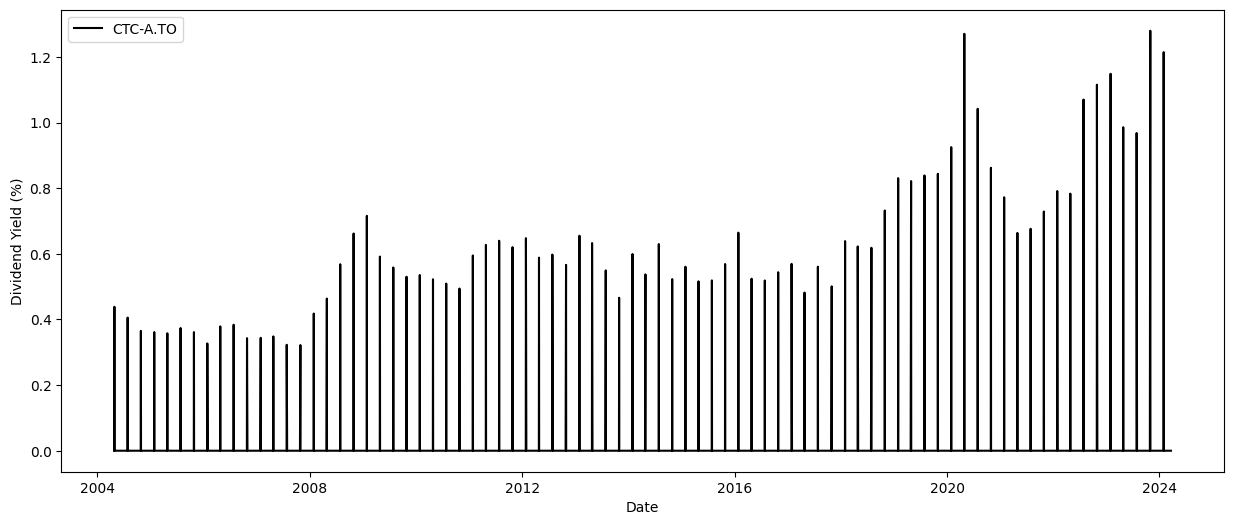

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.670223
share_price      1.000000
Name: share_price, dtype: float64


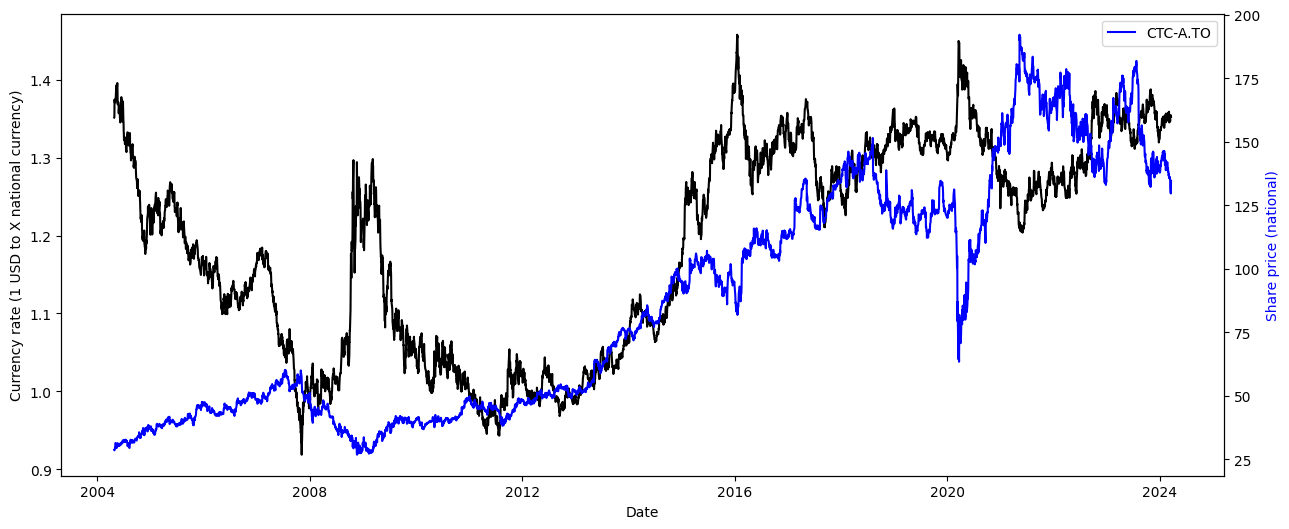

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

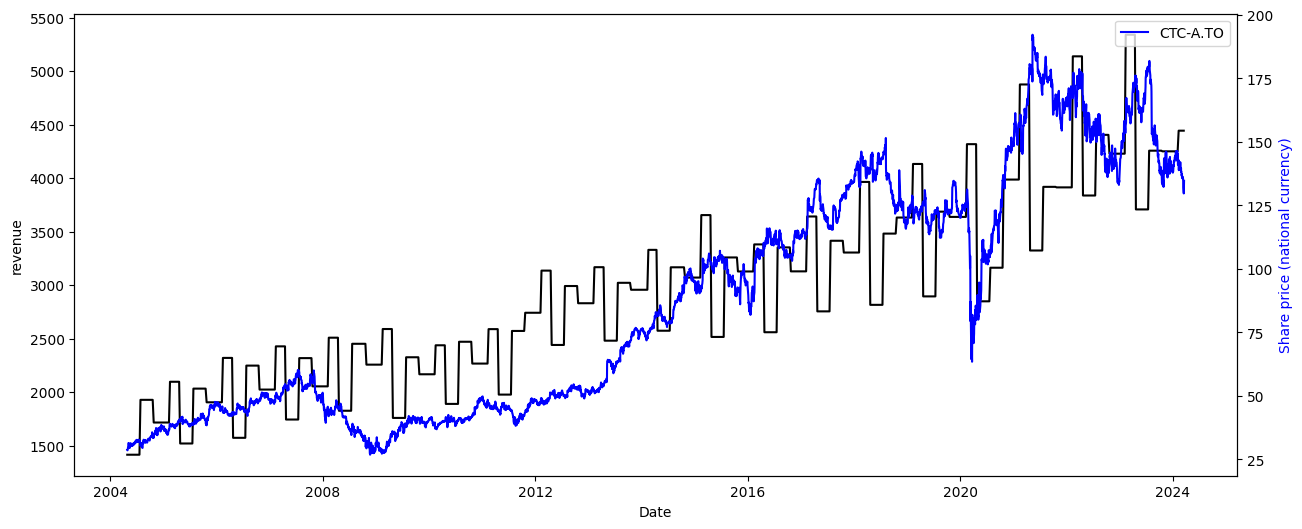

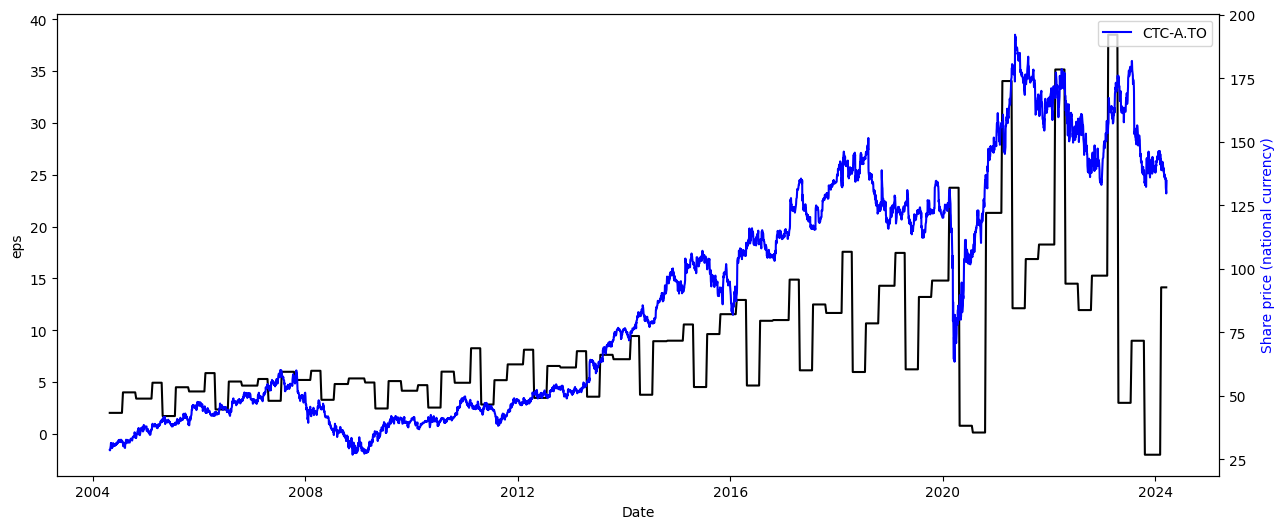

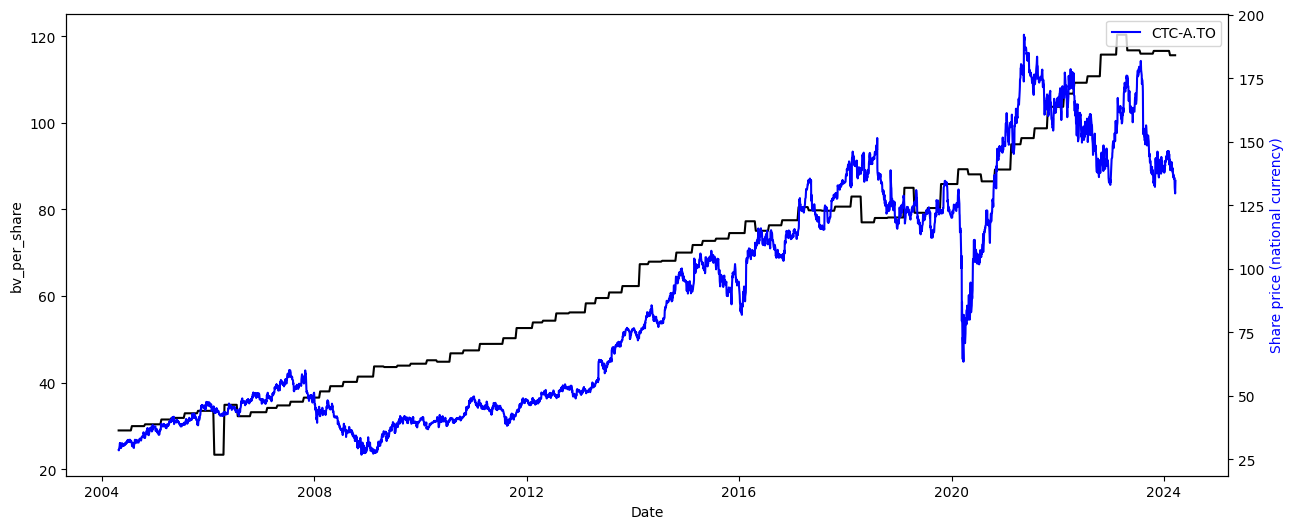

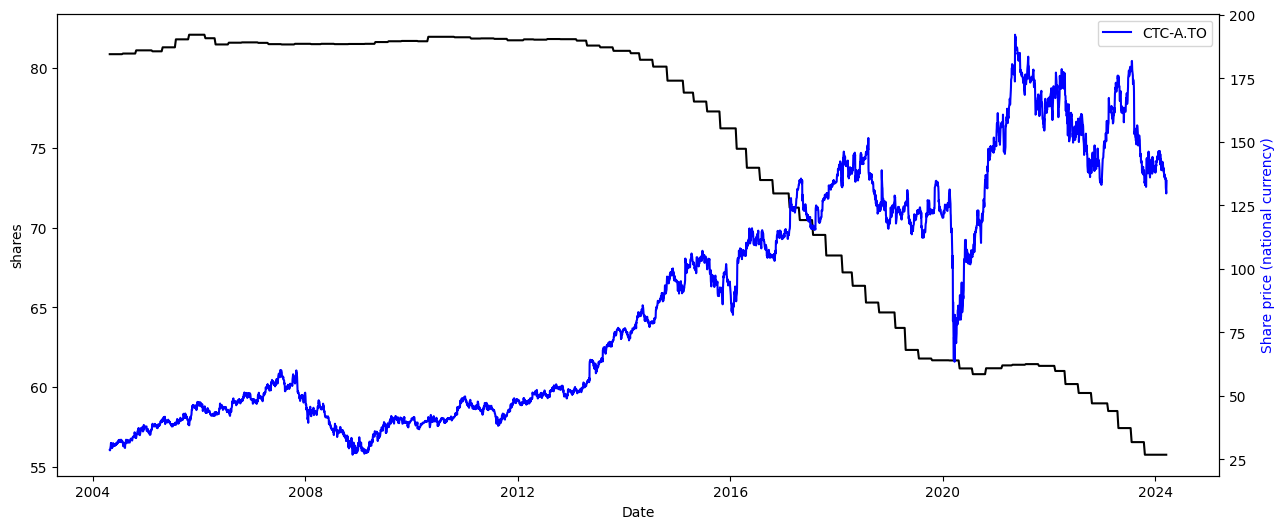

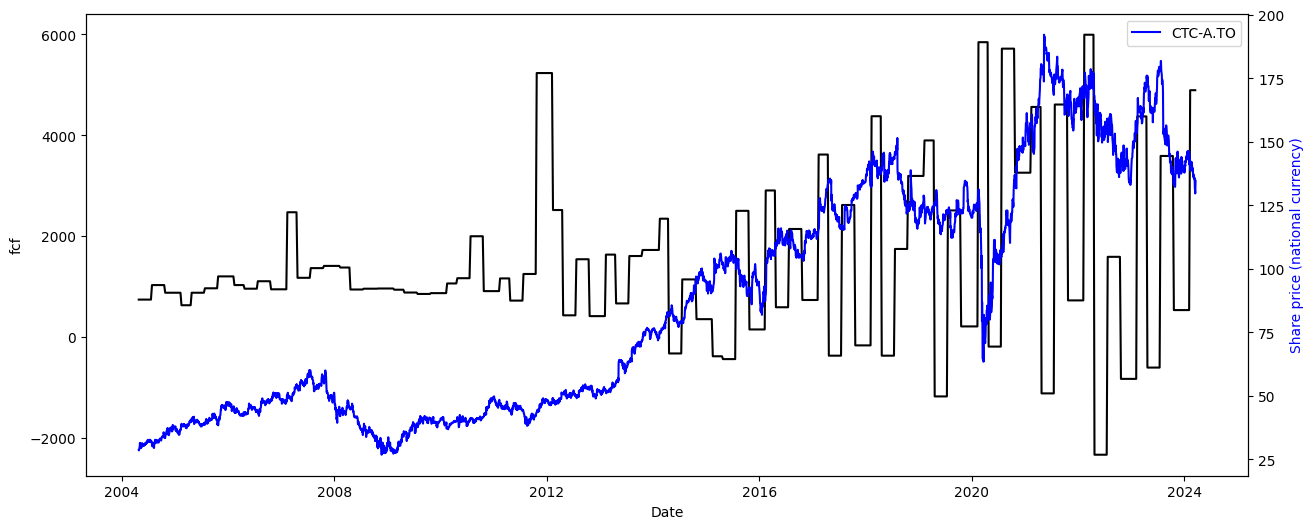

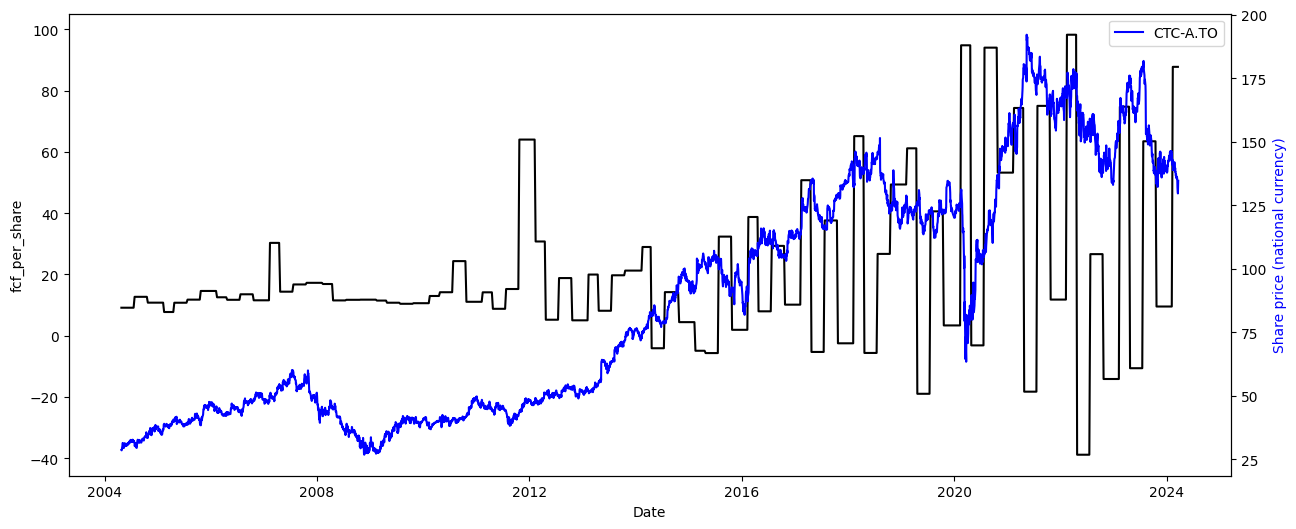

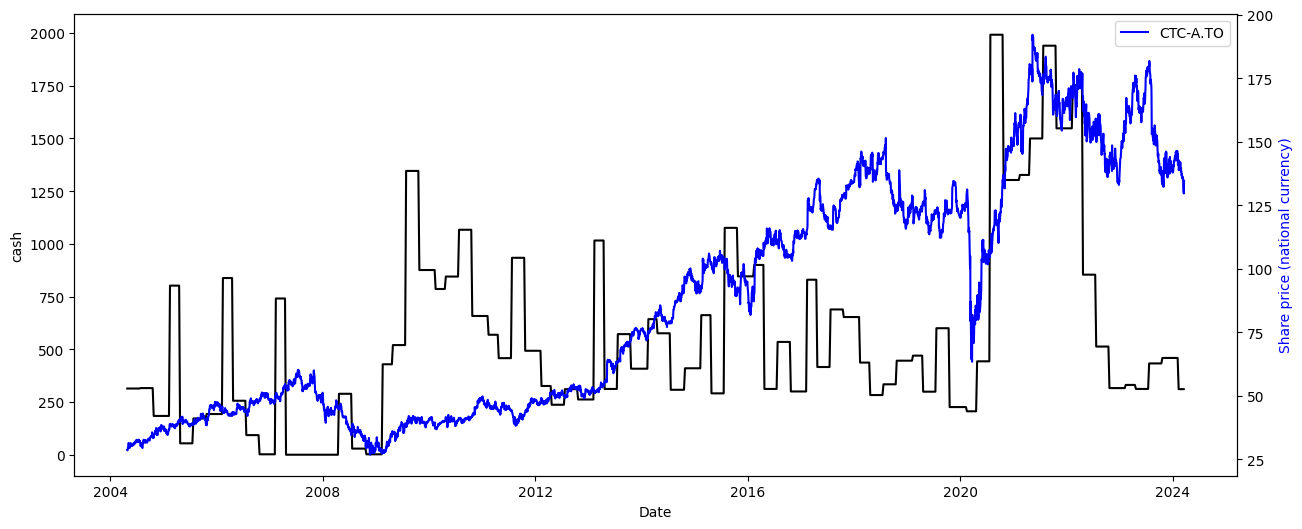

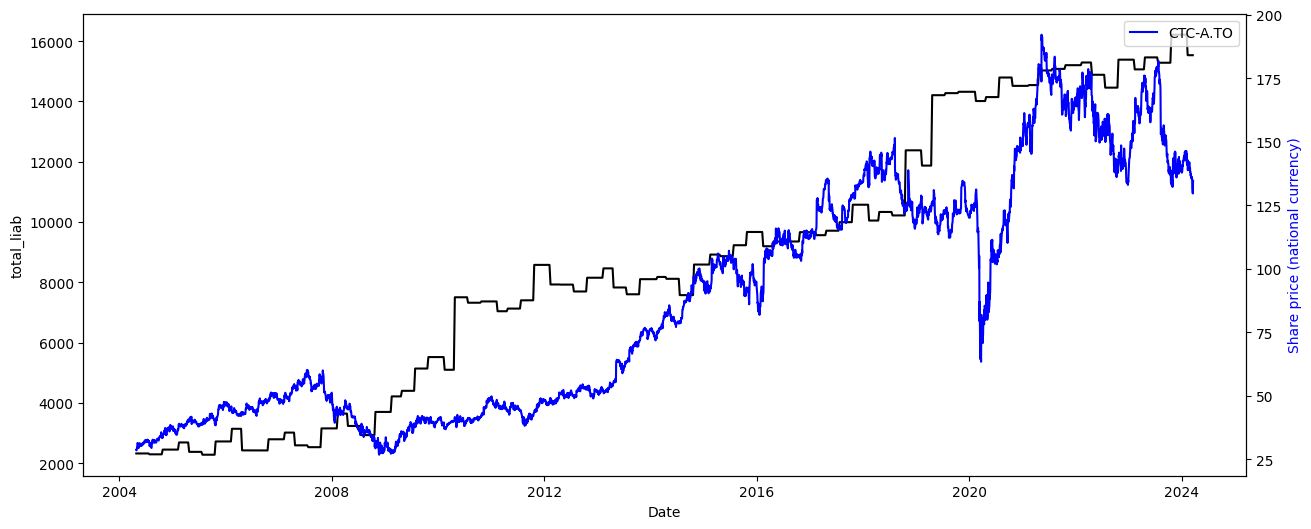

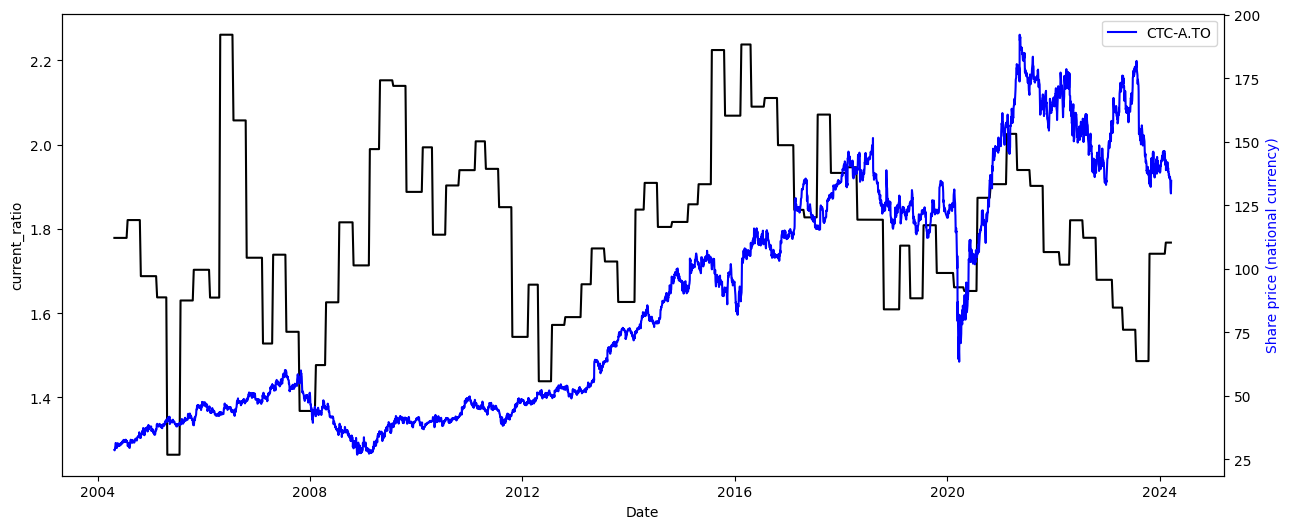

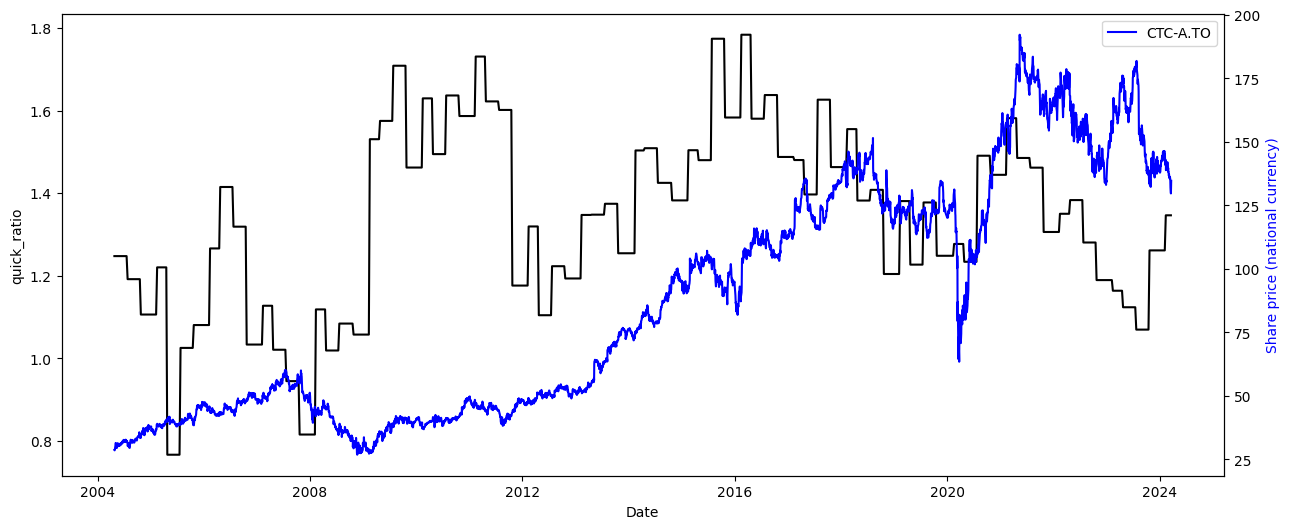

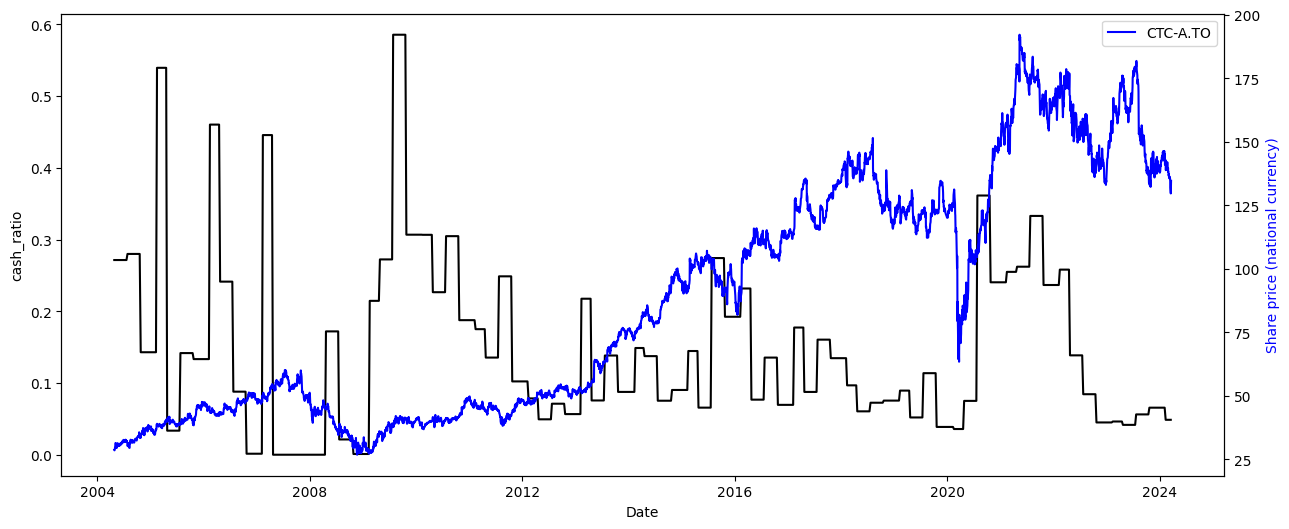

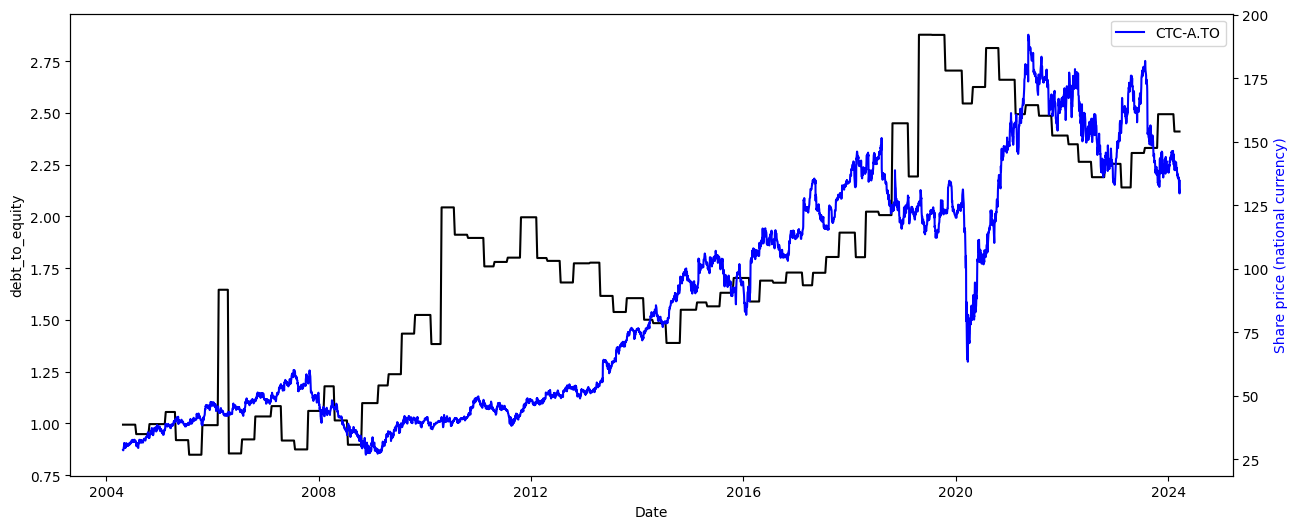

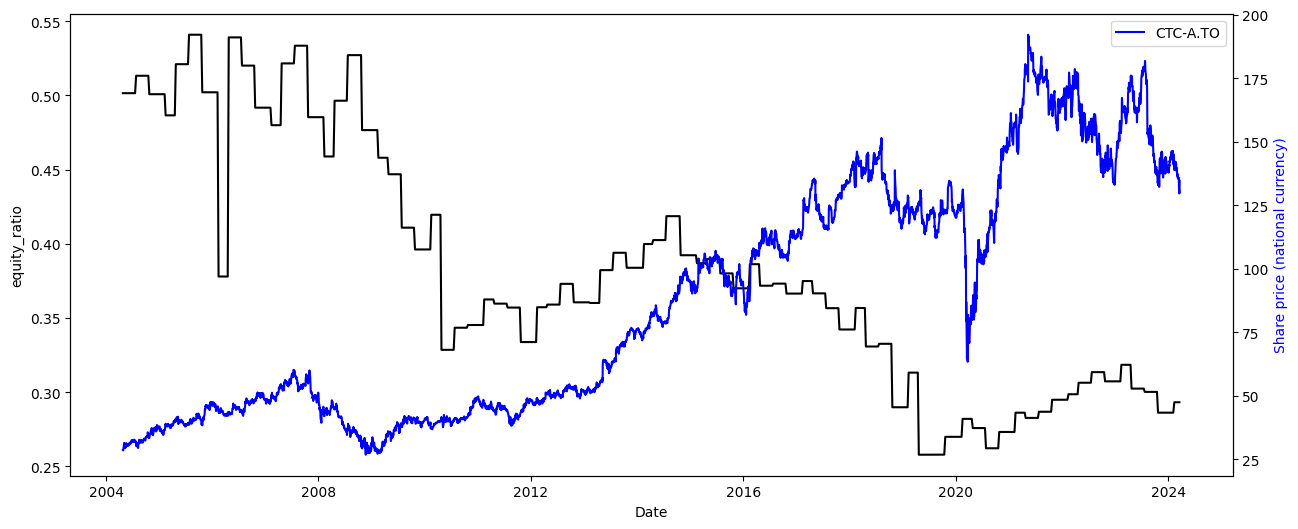

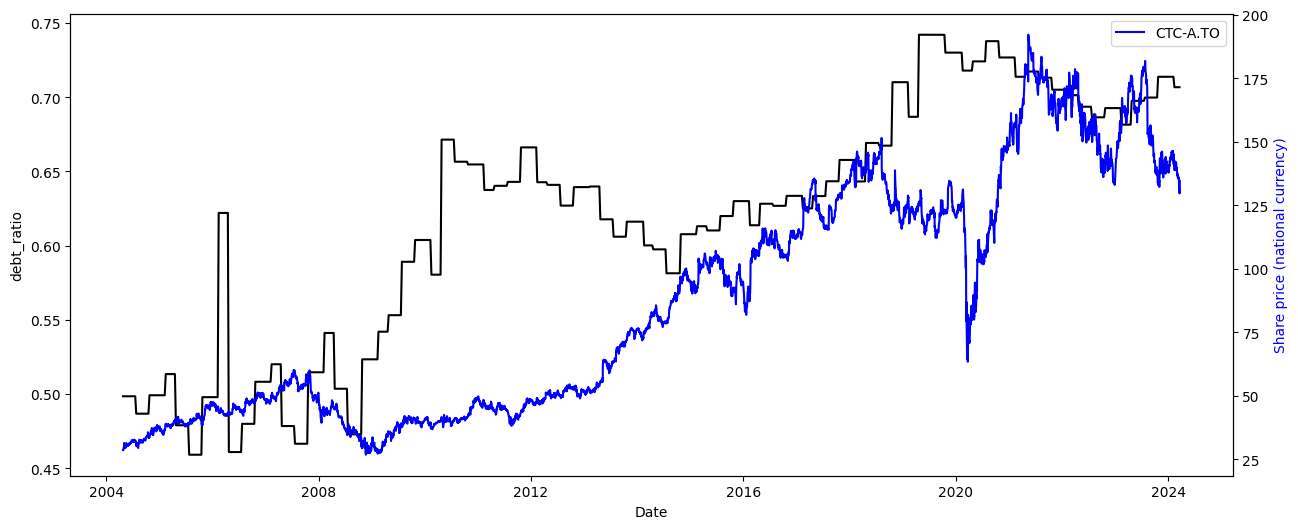

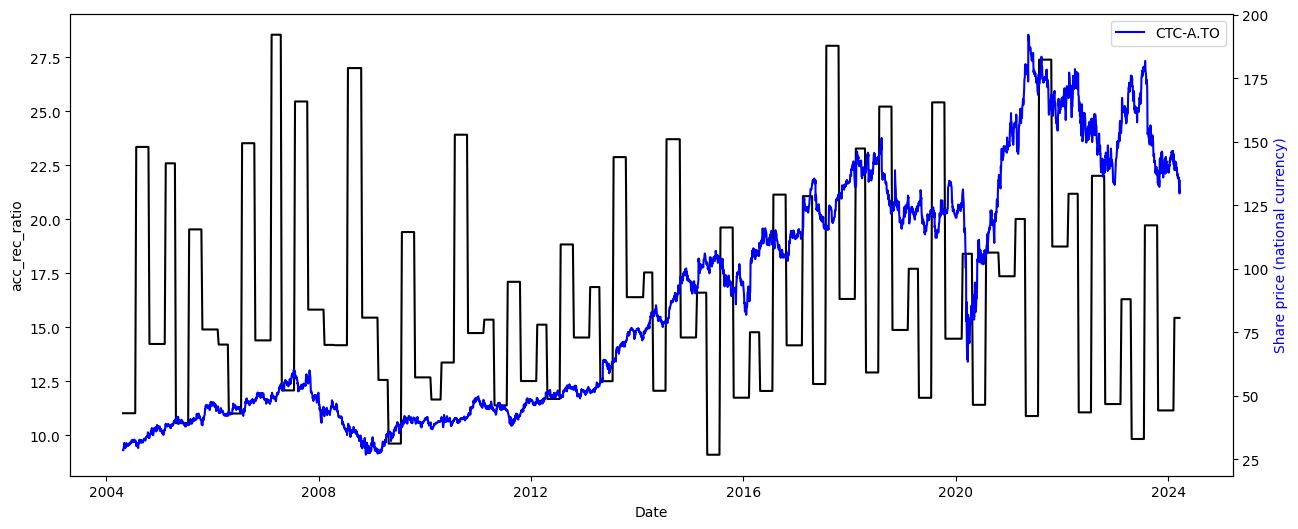

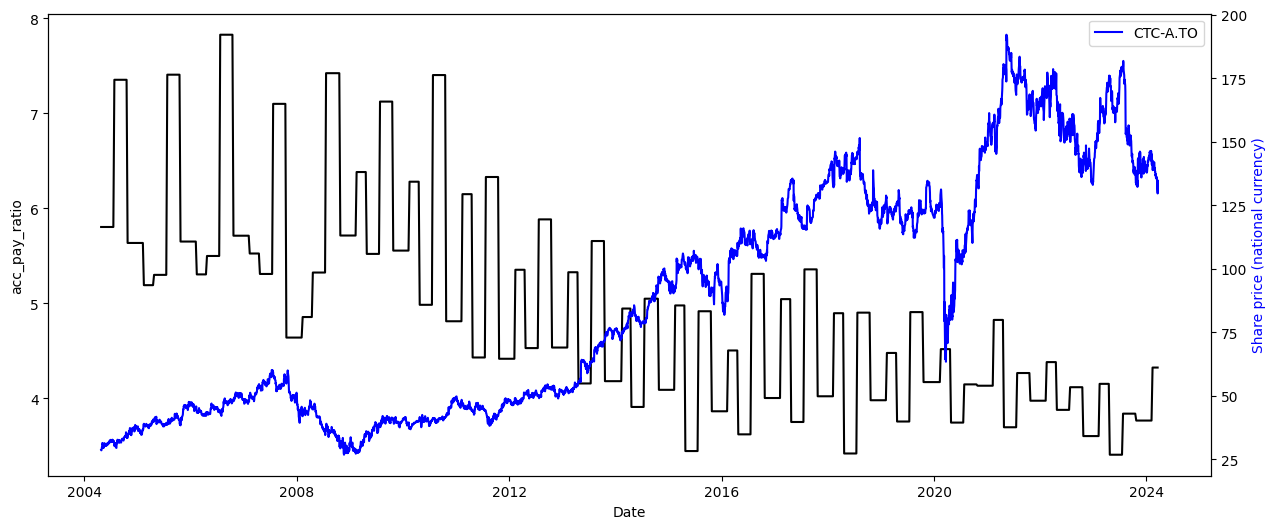

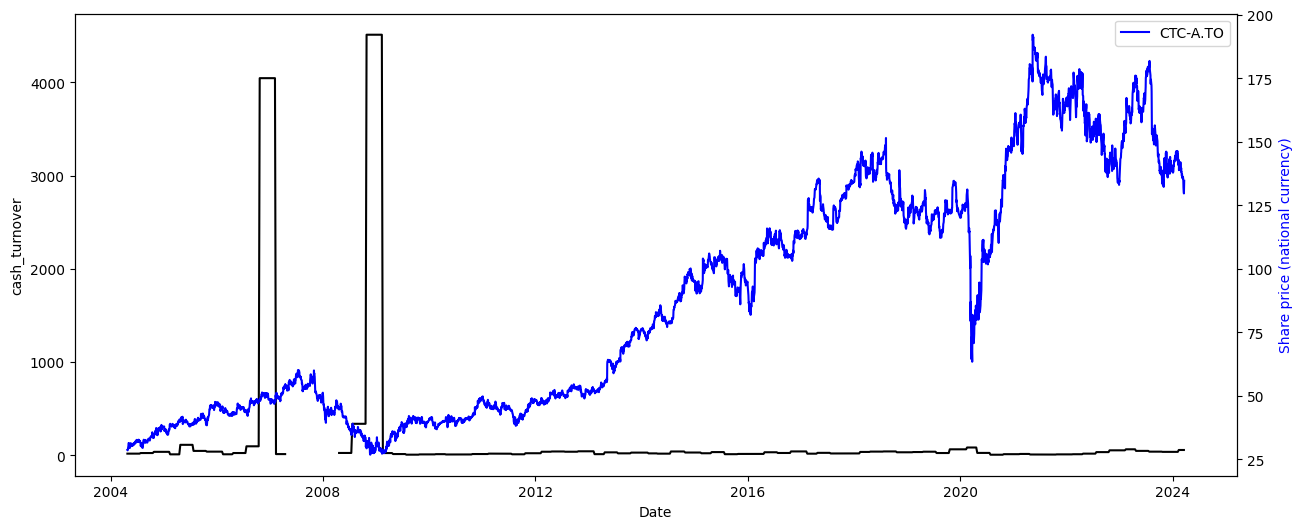

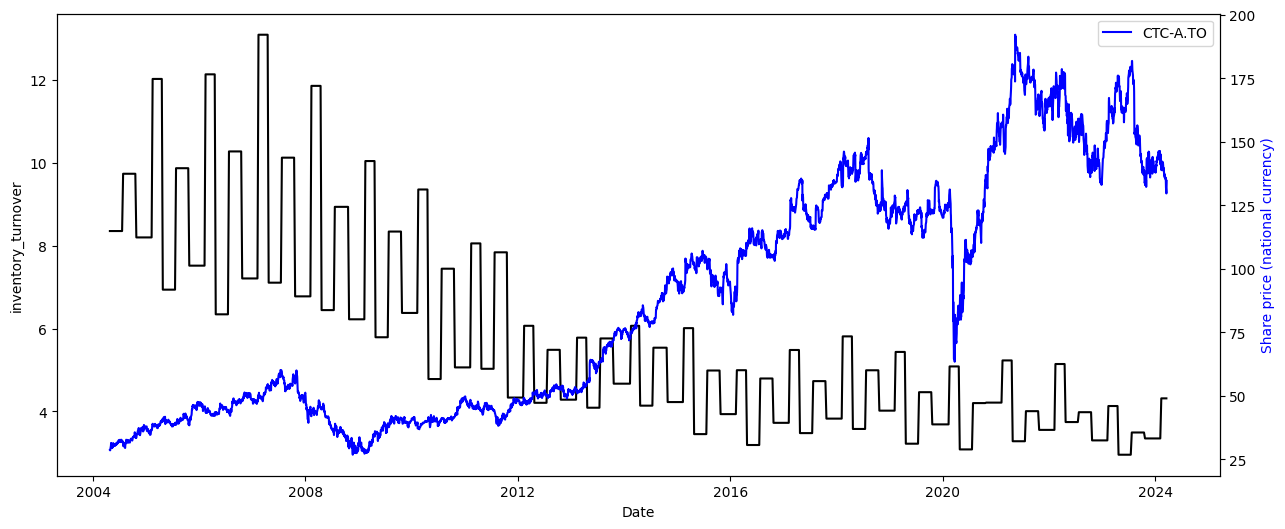

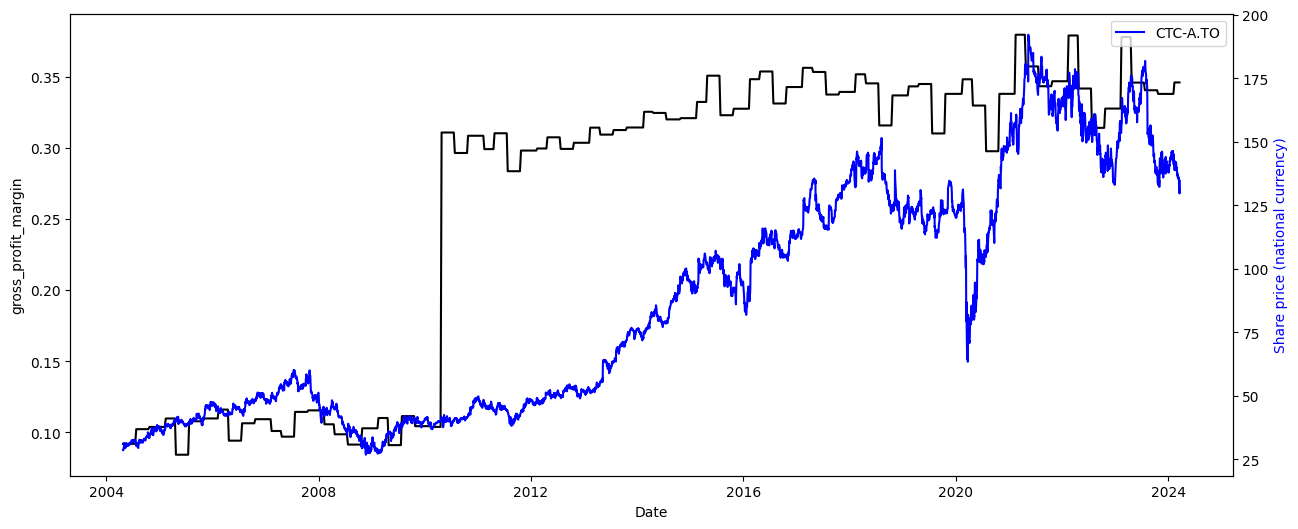

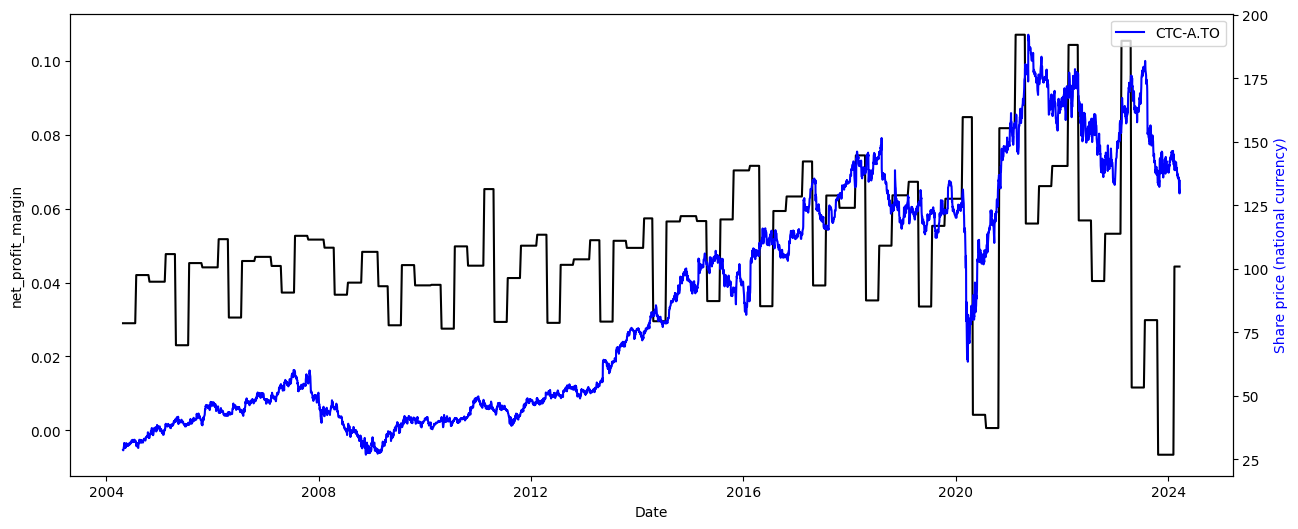

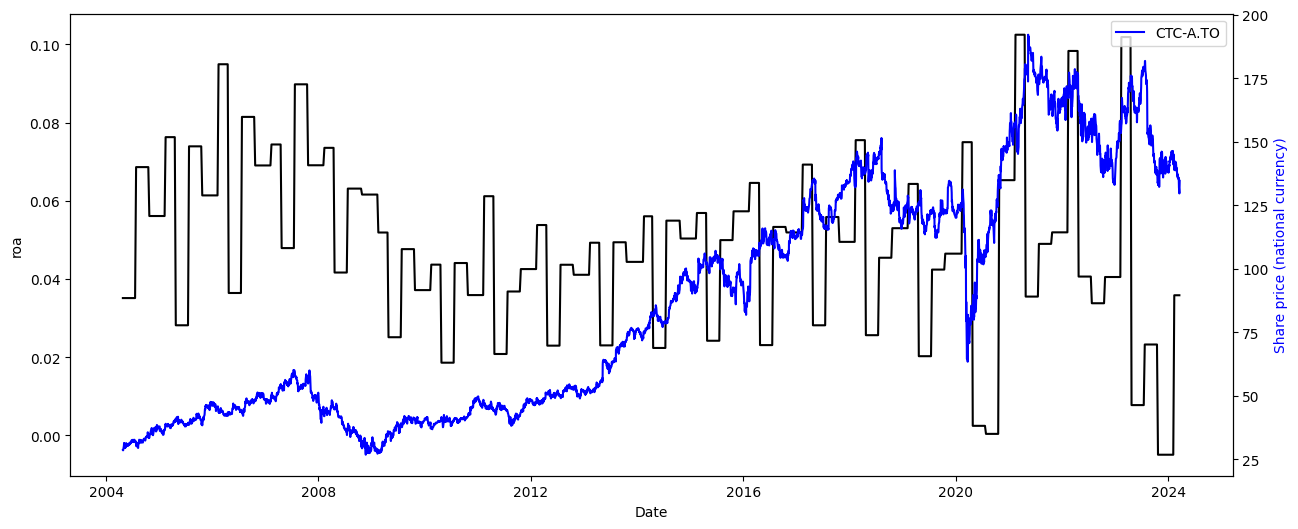

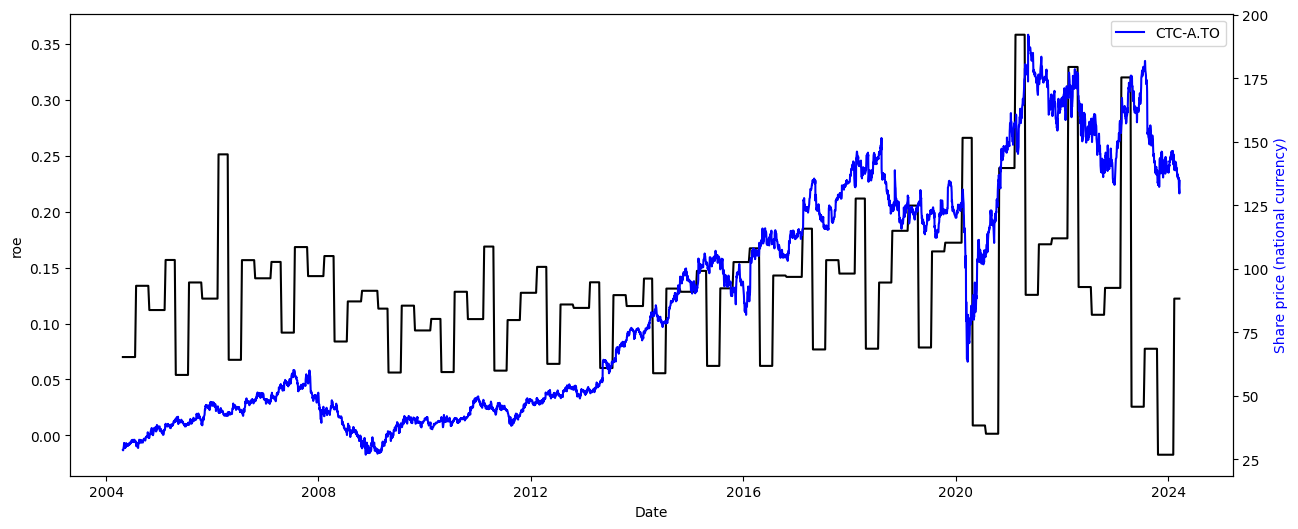

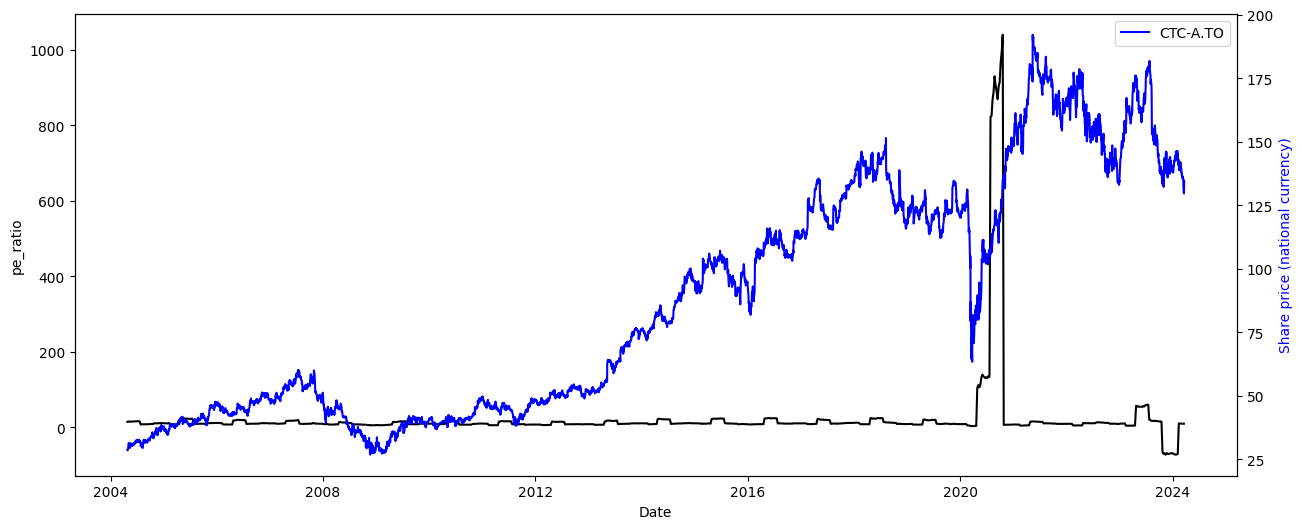

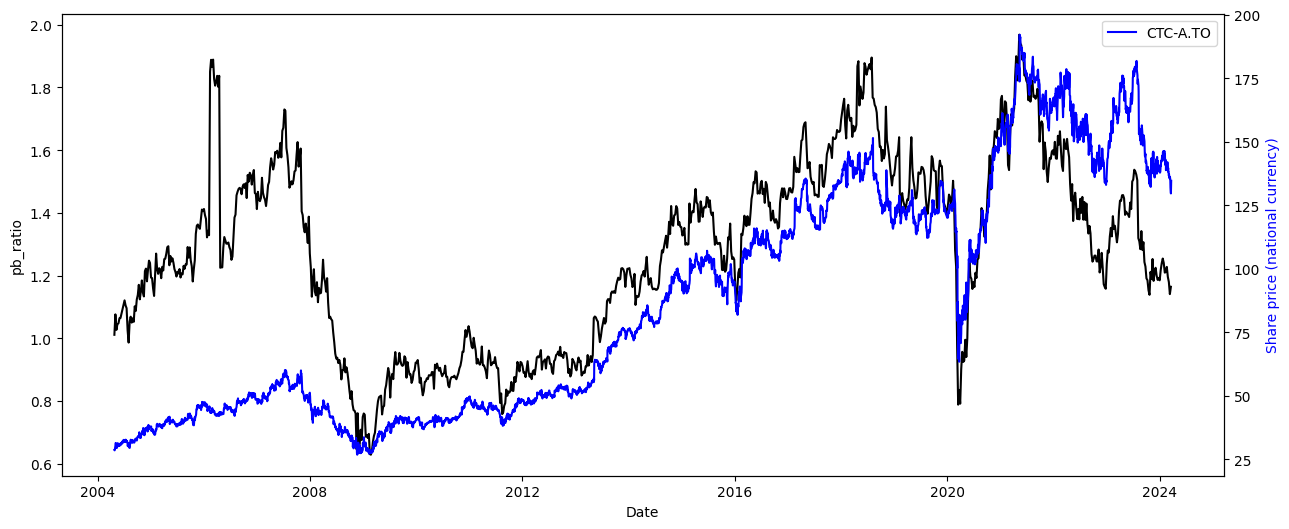

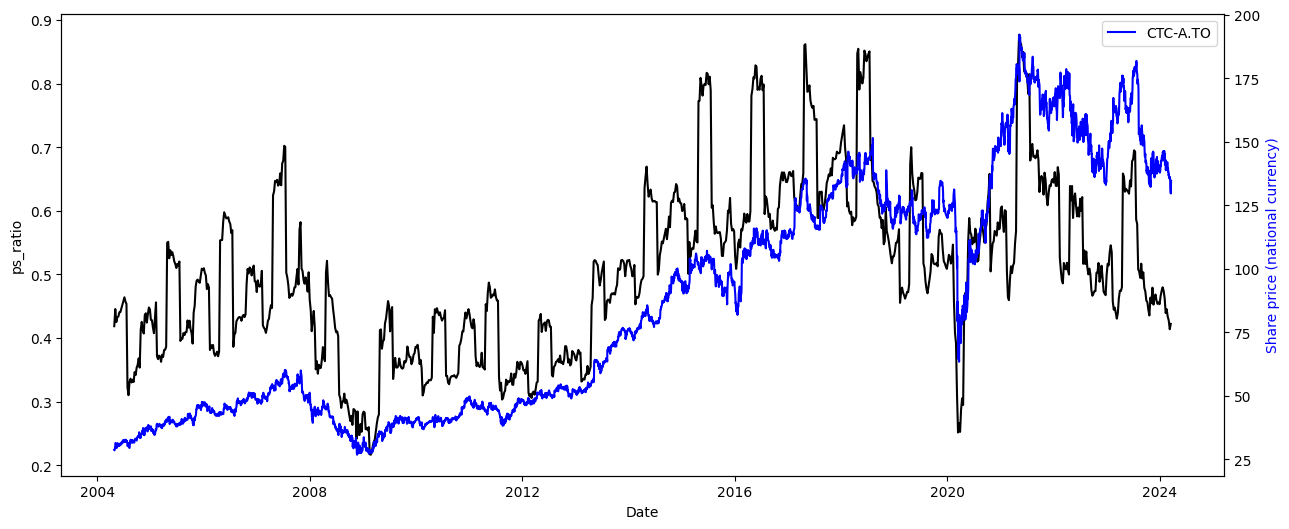

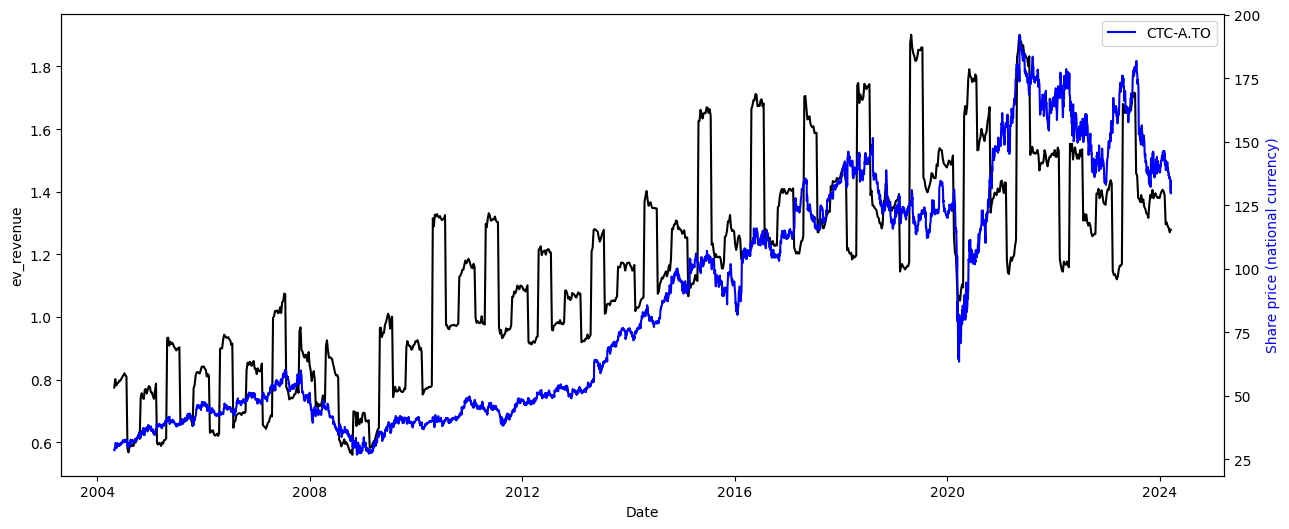

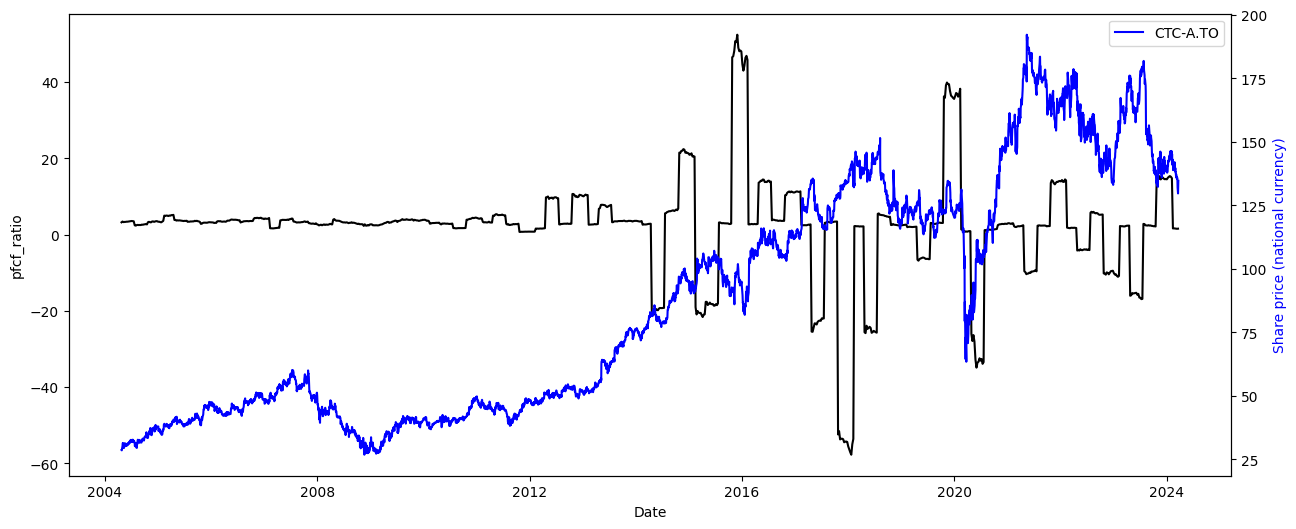

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

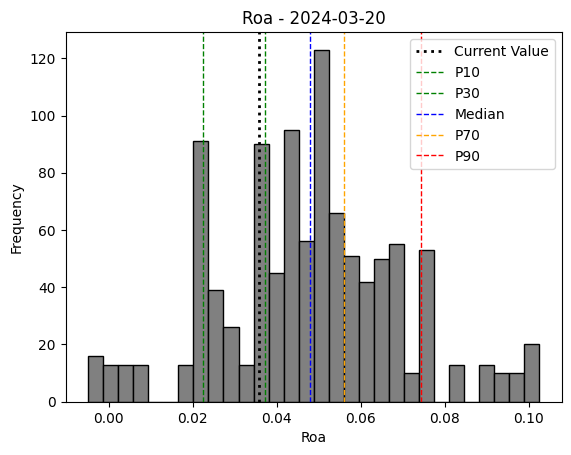

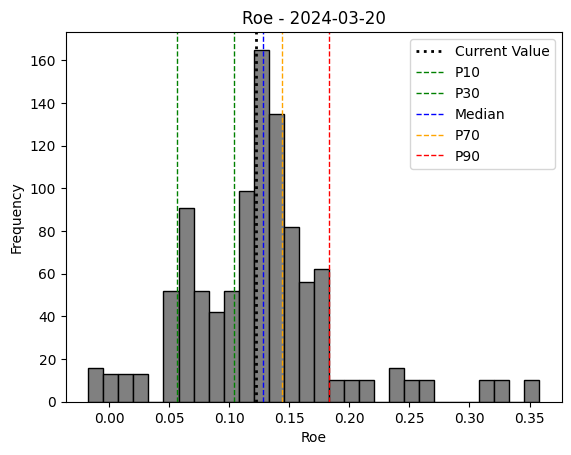

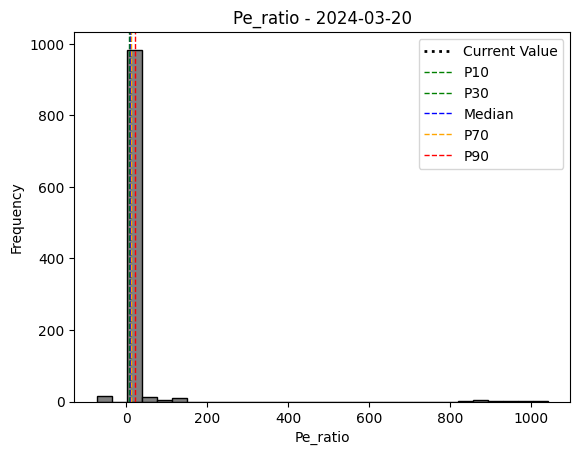

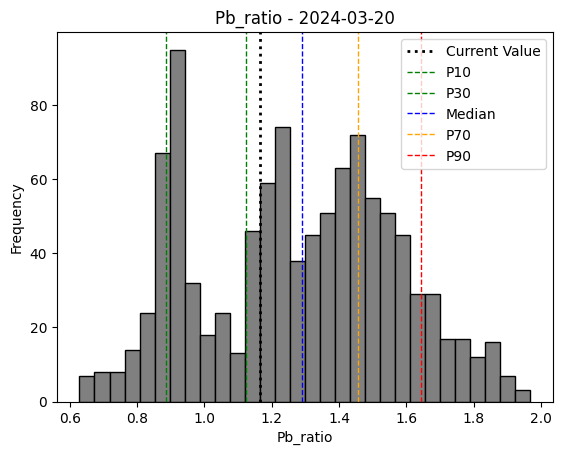

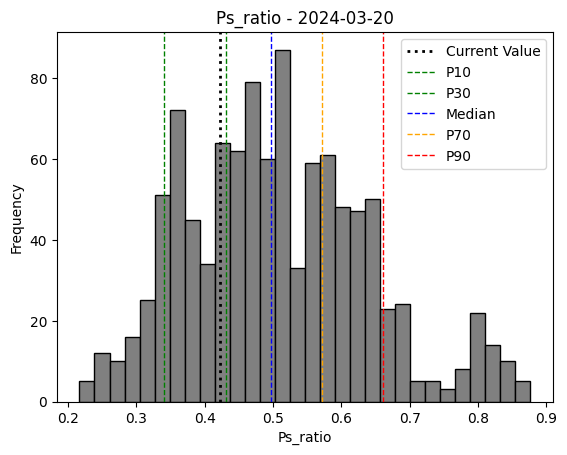

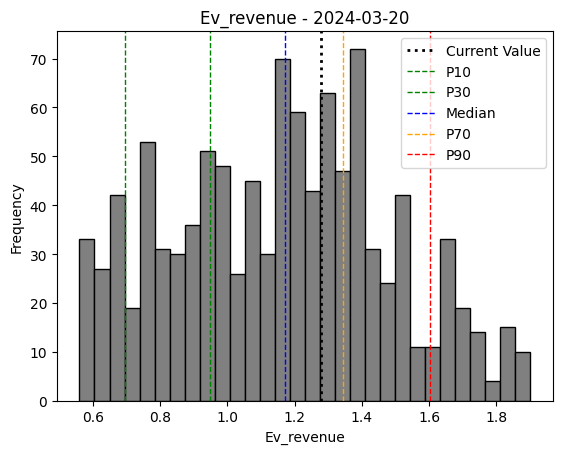

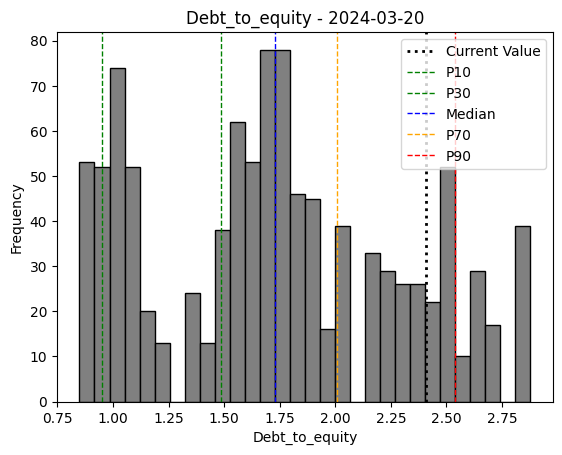

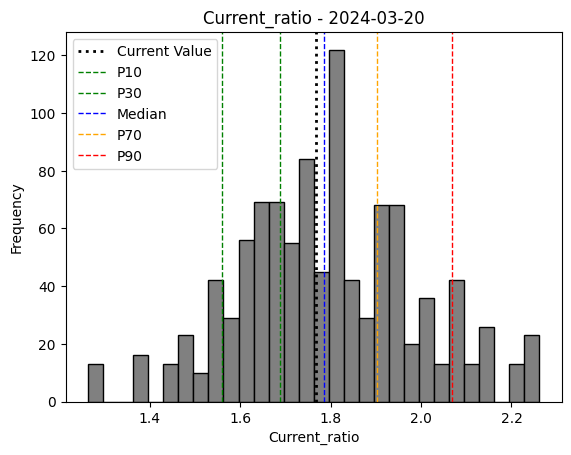

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.876577,-0.278528,0.222782,-0.257931,-0.540823,-0.318324,-0.018105
roe,0.876577,1.000000,-0.256267,0.344661,-0.104384,-0.184192,0.131052,0.030012
pe_ratio,-0.278528,-0.256267,1.000000,0.052130,0.100437,0.193325,0.217948,0.033018
pb_ratio,0.222782,0.344661,0.052130,1.000000,0.776659,0.487357,0.309715,0.063521
ps_ratio,-0.257931,-0.104384,0.100437,0.776659,1.000000,0.774241,0.306017,0.234510
ev_revenue,-0.540823,-0.184192,0.193325,0.487357,0.774241,1.000000,0.776595,0.130326
debt_to_equity,-0.318324,0.131052,0.217948,0.309715,0.306017,0.776595,1.000000,0.002945
current_ratio,-0.018105,0.030012,0.033018,0.063521,0.234510,0.130326,0.002945,1.000000


35 timestemos have been found!


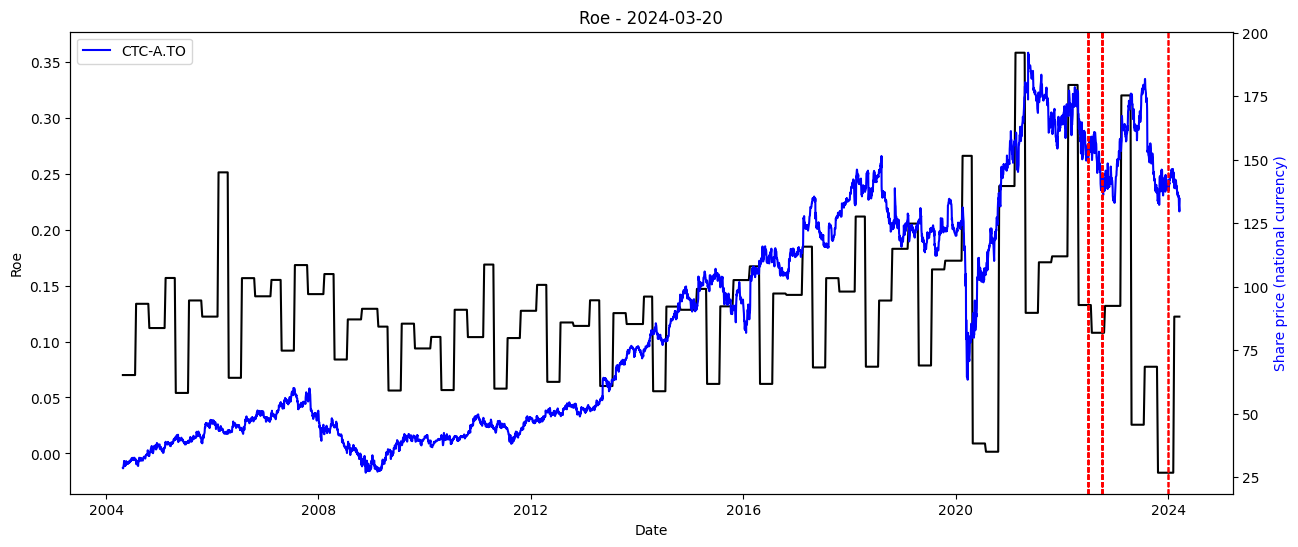

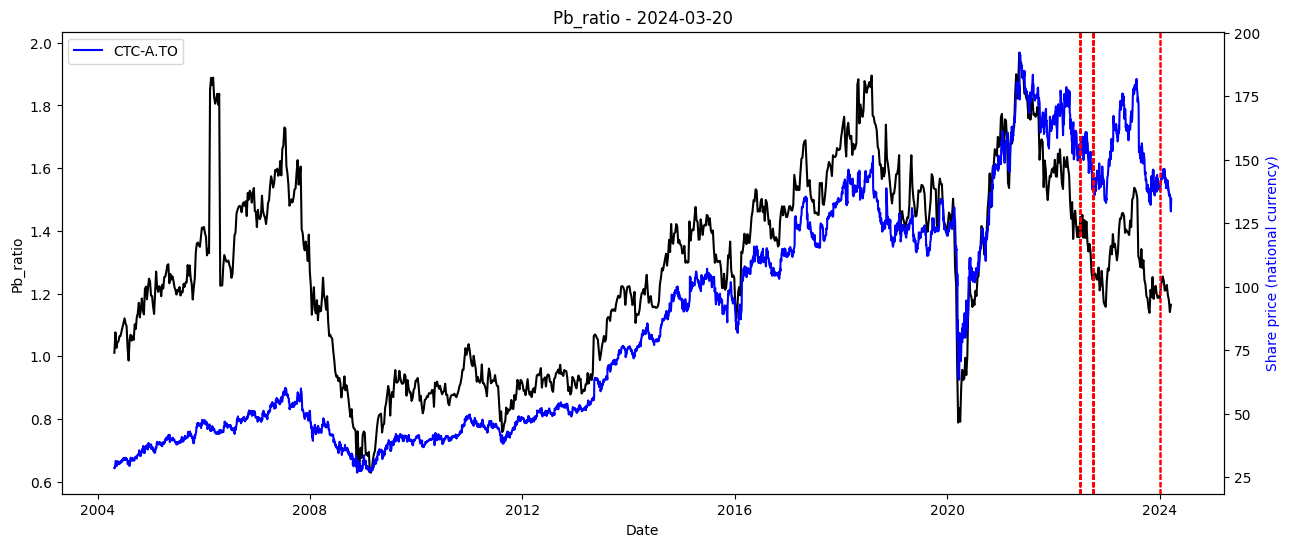

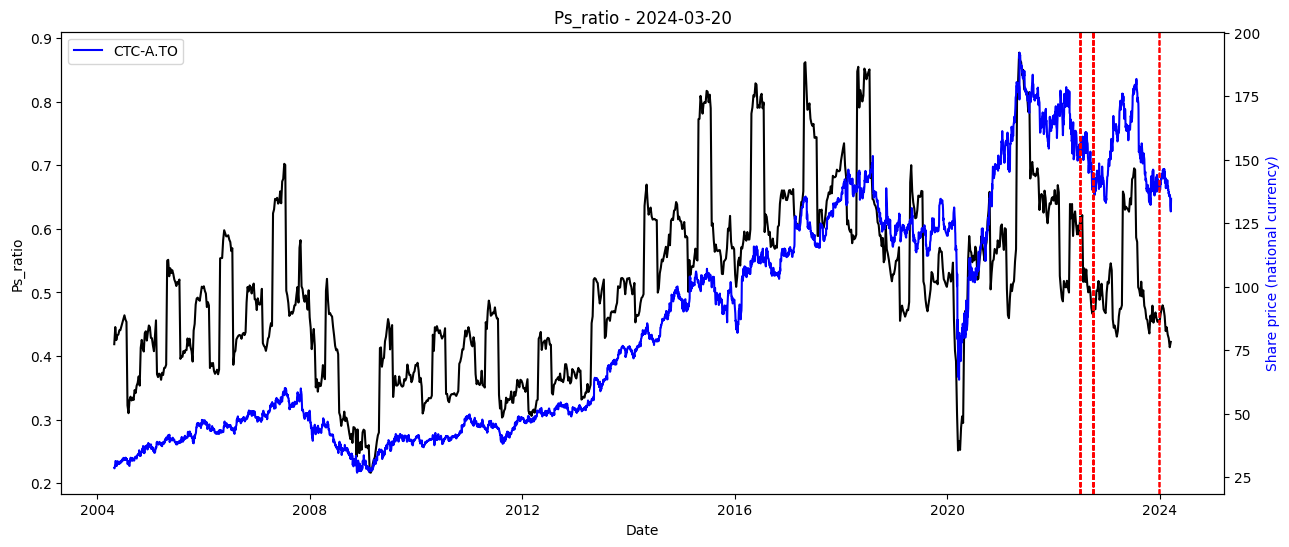

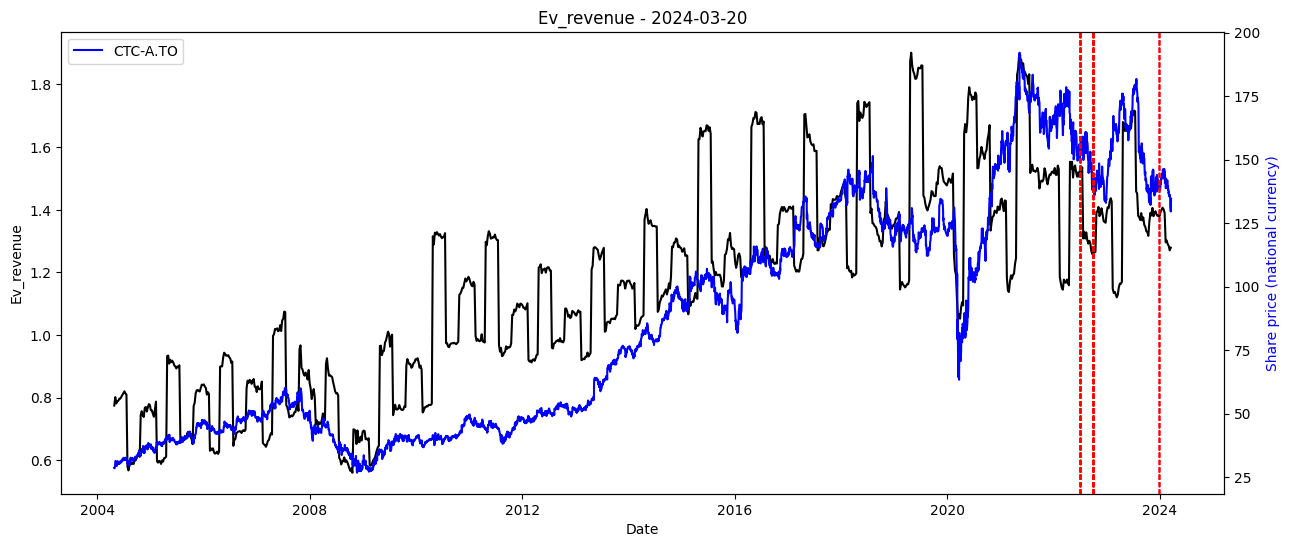

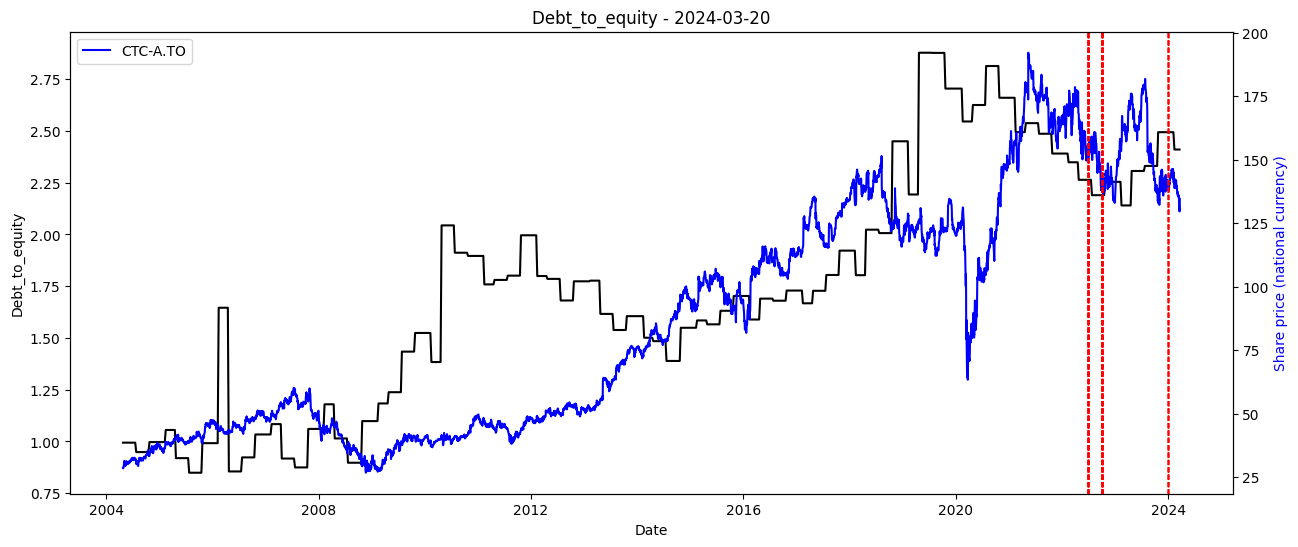

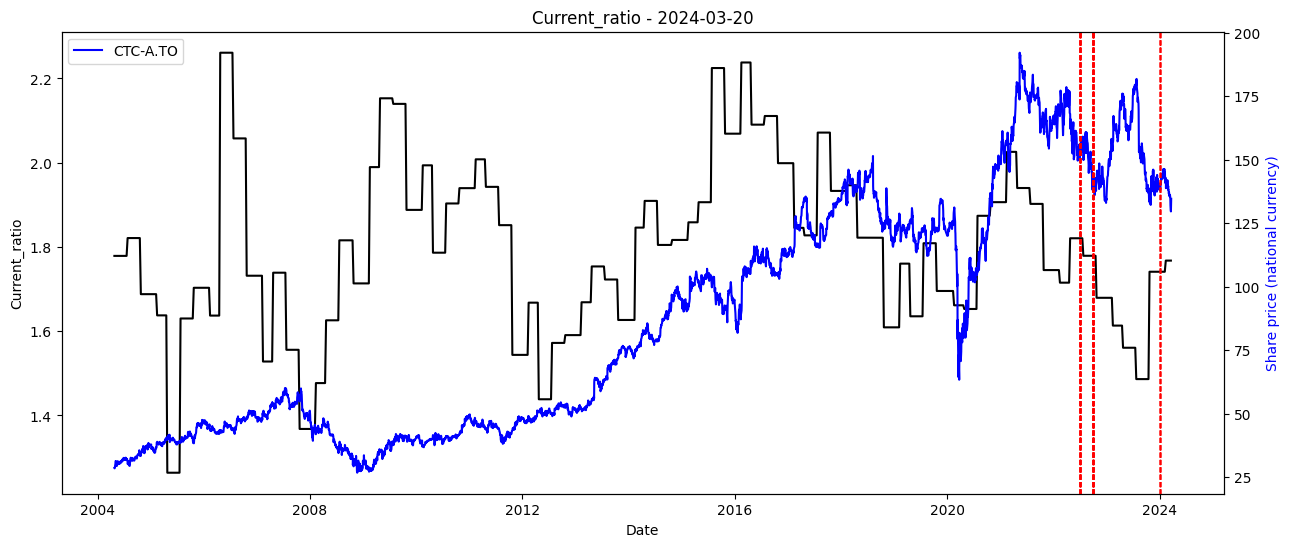

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )